In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import special

In [2]:
def dG(lambdas, charges, v):
    """
    Numerical integration based on Maria Reif 2014(?) article, eq. 12
    where v is written phi in the article
    """
    dG = 0
    for i in range(1,len(lambdas)):       
        delta_lambda = lambdas[i] - lambdas[i-1]
        delta_q = charges[len(lambdas)-1] - charges[0]         
        for atom in range(0, len(delta_q)):
            dG += delta_q[atom] * delta_lambda * (v[i][atom] + v[i-1][atom])/2 
    return dG

def parse_charges(path_dgslv_pbsolv):
    """
    extract data from the output of gromos++ dGslv_pbsolv calculations
    """
    data = np.loadtxt(path_dgslv_pbsolv, skiprows=1, dtype=str)
    return np.array(data.T[3], dtype=float)

def parse_potentials(path_dgslv_pbsolv):
    """
    extract data from the output of gromos++ dGslv_pbsolv calculations
    """
    
    data = np.loadtxt(path_dgslv_pbsolv, skiprows=1, dtype=str)
    return np.array(data.T[4:], dtype=float)


def find_missing_indices(basedir):
    """
    Checks the data in dG_pol to see if any is missing.
    Returns list of indices for which full data is available.
    """
    n_snapshots = 50
    lambda_idx = np.arange(1, 12, 1)
    indices_full =[]
    for k in range(n_snapshots):
        incomplete_data = np.any([os.path.getsize(f'{basedir}/dg_pol/dgsolv_lam_{lam}_{k+1}.out') == 0 for lam in lambda_idx])

        if incomplete_data:
            continue

        indices_full.append(k)
    
    return indices_full


def calc_partial_dg_pol(basedir, indices_full):
    """
    Calculate dG_pol for the data which is complete
    """
    n_snapshots = 50
    lambdas = np.arange(0, 1.001, 0.1)
    lambda_idx = np.arange(1, 12, 1)
    n_pots = 6
    
    all_data = np.zeros([len(indices_full), n_pots+1])

    for k_prime, k in enumerate(indices_full):
        charges = np.array([parse_charges(f'{basedir}/dg_pol/dgsolv_lam_{lam}_{k+1}.out') for lam in lambda_idx])
        pot_energies = np.array([parse_potentials(f'{basedir}/dg_pol/dgsolv_lam_{lam}_{k+1}.out') for lam in lambda_idx])

        pot_labels = ['DG_POL', 'NPBC_SLV', 'NPBC_VAC','PBC_SLV', 'PBC_VAC', 'FFT_LS_PBC', 'FFT_RF_PBC']

        for i in range(n_pots):
            all_data[k_prime][i+1] = dG(lambdas, charges, pot_energies[:,i,:])
        all_data[k_prime][0] = (all_data[k_prime][1] - all_data[k_prime][2]) - (all_data[k_prime][3] - all_data[k_prime][4]) + (all_data[k_prime][5] - all_data[k_prime][6])
    
    
    return np.round(np.average(all_data.T[0]),2), all_data

# Functions doing the calculation for dG_dir

In [3]:
def parse_file(path_dgdir):
    """
    extract data from the output of gromos++ dGslv_pbsolv calculations
    """
    return np.loadtxt(path_dgdir, skiprows=1, dtype=float).T[1]

def calc_dgdir_partial(basedir, indices_full):
    
    traj_indices = np.arange(1, 12, 1)
    lambdas = np.arange(0, 1.001, 0.1)
    
    v_npbc = np.array([ parse_file(f'{basedir}/dg_dir/dgdir_lam_{i}.txt') for i in traj_indices])
    v_pbc = np.array([ parse_file(f'{basedir}/dg_dir/dgdir_lam_{i}_withPBC.txt') for i in traj_indices])

    dg_dir = np.trapz(v_npbc.T, x = lambdas) - np.trapz(v_pbc.T, x = lambdas)
    # np.save('deltaG_dir.npy', dg_dir, )
    avg = np.round(np.average(dg_dir), 2)
    std = np.round(np.std(dg_dir), 2)
    
    return dg_dir, dg_dir[indices_full]

# Do the calculation for a system of interest

### Note: This data is not made available on GitHub as some files are too large, if you would like to have access to the raw data, please contact the corresponding author (sriniker@ethz.ch)

In [182]:
ligand_id = 1

In [183]:
basedir = f'/fileserver/pine/pine2/cchampion/REEDS/2_protonation/FXA_charging_deltaGs/ligand{ligand_id}/complex/corr_factors'

In [184]:
indices_full = find_missing_indices(basedir)

In [185]:
avg, dg_pol = calc_partial_dg_pol(basedir, indices_full)

In [186]:
dg_dir, dg_dir_part = calc_dgdir_partial(basedir, indices_full)

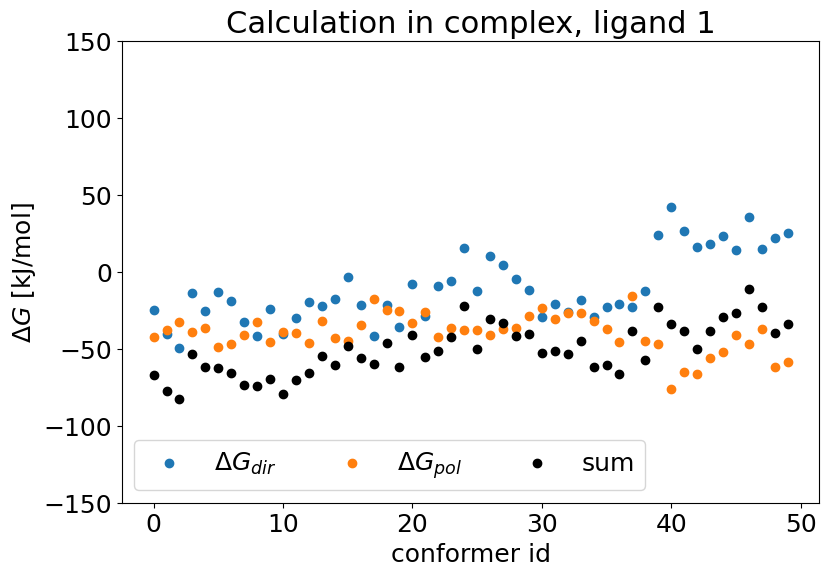

In [187]:
fontsize = 18

fig, ax = plt.subplots(1, 1, figsize = [9, 6])

ax.scatter(indices_full, dg_dir_part, label = r'$\Delta{G_{dir}}$')
ax.scatter(indices_full, dg_pol.T[0], label = r'$\Delta{G_{pol}}$')

ax.scatter(indices_full, dg_dir_part + dg_pol.T[0], label = 'sum', color = 'black')

ax.set_ylim([-150, 150])

ax.legend(loc='lower left', fontsize = fontsize, ncols=3)
    
ax.set_ylabel(r'$\Delta{G}$ [kJ/mol]', fontsize = fontsize)
ax.set_xlabel(r'conformer id', fontsize = fontsize)
ax.set_title(f'Calculation in complex, ligand {ligand_id}', fontsize = 22)

ax.tick_params(axis='both', labelsize=fontsize)



In [188]:
fig.savefig(f'/home/cchampion/Desktop/charge_corr_ligand_{ligand_id}.pdf', dpi=100)

# Calculate basic average

In [16]:
def print_all_data(indices_full, dg_pol, dg_dir_part):
    
    dg_pol_avg = np.round(np.average(dg_pol.T[0]), 2)
    dg_dir_avg = np.round(np.average(dg_dir_part), 2)
    
    dg_comb = dg_pol_avg + dg_dir_avg
    
    print (f'n = {len(indices_full)}')
    print (f'dg_pol = {dg_pol_avg}')
    print (f'dg_dir = {dg_dir_avg}')
    print (f'{dg_comb=}')
    
    # Get an ensemble average:
    
    RT = 2.479
    exp_term  = - (dg_dir_part + dg_pol.T[0]) / RT

    ensemble_avged = -(RT) * (special.logsumexp(exp_term) - np.log(len(exp_term)))
    print (f'{ensemble_avged=:.2f}')

In [17]:
print_all_data(indices_full, dg_pol, dg_dir_part)

n = 50
dg_pol = -47.09
dg_dir = -10.89
dg_comb=-57.980000000000004
ensemble_avged=-76.88


# Print the data (csv) to latex table

In [18]:
import pandas as pd

path_dat = '/fileserver/pine/pine2/cchampion/REEDS/2_protonation/paper_programs/data/FXA/charge_correction'

corr_sol = pd.read_csv(f'{path_dat}/correction_factors_solution.csv')
corr_com = pd.read_csv(f'{path_dat}/correction_factors_complex.csv')

In [19]:
def print_to_table(corr_data):
    
    str_table = '\\begin{tabular}{ | c | c | c | c | c |}\n'
    str_table += '\hline\n'
    str_table += 'Ligand ID & $\Delta{G_{dsm}}$ [kJ/mol] &  $\Delta{G_{pol}}$ [kJ/mol] & $\Delta{G_{dir}}$ [kJ/mol] & $\Delta{G_{cor}}$ [kJ/mol] \\\\ \n'
    str_table += '\hline\n'
    
    for i, row in corr_data.iterrows():
        str_table += f'{int(row[0])} & {row[1]} &  {row[2]} &  {row[3]} &  {row[4]} \\\\ \n'
            
    str_table += '\hline\n'
    str_table += '\end{tabular}\n'
    print (str_table)

In [20]:
print_to_table(corr_com)

\begin{tabular}{ | c | c | c | c | c |}
\hline
Ligand ID & $\Delta{G_{dsm}}$ [kJ/mol] &  $\Delta{G_{pol}}$ [kJ/mol] & $\Delta{G_{dir}}$ [kJ/mol] & $\Delta{G_{cor}}$ [kJ/mol] \\ 
\hline
1 & -29.48 &  -40.04 &  -10.68 &  -80.2 \\ 
2 & -27.12 &  -52.32 &  -4.96 &  -84.4 \\ 
3 & -28.35 &  -47.23 &  -4.5 &  -80.08 \\ 
4 & -27.89 &  -51.13 &  3.21 &  -75.81 \\ 
5 & -29.23 &  -54.54 &  -1.1 &  -84.87 \\ 
6 & -28.78 &  -54.43 &  -5.51 &  -88.72 \\ 
7 & -29.57 &  -48.41 &  -18.93 &  -96.91 \\ 
8 & -29.64 &  -47.09 &  -10.89 &  -87.62 \\ 
\hline
\end{tabular}



# save the overall correction factor for each ligand

In [25]:
np.save(f'{path_dat}/overall_correction.npy', corr_com['sum'] - corr_sol['sum'])

In [26]:
np.load(f'{path_dat}/overall_correction.npy')

array([-12.91, -17.27, -13.26,  -7.06, -17.75, -21.55, -30.37, -19.81])